# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import matplotlib.dates as dates
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [2]:
def preprocessing():
    # Read the Data file
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

    # Sort values by Date
    df.sort_values(by=['Date'],inplace=True)
    df.reset_index(inplace=True, drop=True)

    # Required Period from 2005 to 2015
    last_year_index = df.loc[df['Date'] == '2015-12-31'].index.to_series().idxmax()
    df1 = df[0:last_year_index]

    # Tenth of Temperature
    df['Data_Value'] = df['Data_Value']*0.1

    # Year and Month columns
    df['Year'] = df['Date'].apply(lambda x: x[:4])
    df['Day Of Month'] = df['Date'].apply(lambda x: x[5:])

    # Step 3
    # Remove 02-29 for visualization purposes
    df = df[df['Day Of Month'] != '02-29']
    return df

In [3]:
def pre_2015():
    
    data = preprocessing()
    data = data[(data.Year < '2015')]
    
    # Create a DataFrame of Max and Minimum values of Date For Data from 2005 to 2014
    Max_of_day = data[(data['Element'] == 'TMAX')].groupby(['Day Of Month'])['Data_Value'].max().to_frame()
    Min_of_day = data[(data['Element'] == 'TMIN')].groupby(['Day Of Month'])['Data_Value'].min().to_frame()
    
    # Rename Columns To concatenate it For Better Reading You Can skip concat
    Max_of_day.rename(columns = {'Data_Value': 'Max_Temp'}, inplace = True)
    Min_of_day.rename(columns = {'Data_Value': 'Min_Temp'}, inplace = True)
    Reading = pd.concat([Max_of_day ,Min_of_day], axis = 1).reset_index()
    #data = data.merge(Reading, how = 'outer' , on = 'Day Of Month')
    # Reading.set_index('Day Of Month',inplace = True)
    # data['Day Of Month'] = data['Day Of Month'].astype(float)
    # Reading['float'] = Reading['Day Of Month'].apply(lambda x: dates.date2num(x))
    return Reading

In [4]:
def get_2015():
    pre2015 = pre_2015()
    data = preprocessing()
    data = data[(data.Year == '2015')]
    
    # Create a DataFrame of Max and Minimum values of Date For Data of 2015
    Max_of_day_2015 = data[(data['Element'] == 'TMAX')].groupby(['Day Of Month'])['Data_Value'].max().to_frame()
    Min_of_day_2015 = data[(data['Element'] == 'TMIN')].groupby(['Day Of Month'])['Data_Value'].min().to_frame()
    
    # Rename Columns To concatenate it For Better Reading
    Max_of_day_2015.rename(columns = {'Data_Value': 'Max_Temp_2015'}, inplace = True)
    Min_of_day_2015.rename(columns = {'Data_Value': 'Min_Temp_2015'}, inplace = True)
    Reading_2015 = pd.concat([Max_of_day_2015 ,Min_of_day_2015], axis = 1).reset_index()
    return Reading_2015

In [5]:
def delta():
    
    df = pre_2015()
    df1 = get_2015()
        
    # Merge pre2015 data and 2015 
    data = df.merge(df1, how = 'outer' , on = 'Day Of Month')  
    
    # Determine if min or max of 2015 is more/less than pre2015
    # np.where Returns values instead of booleans
    # data['Max_Temp_2015'] to match the size
    # if condition not satisfied return np.nan
    data['Max_Temp_2015'] = np.where(data['Max_Temp_2015'] > data['Max_Temp'], data['Max_Temp_2015'], np.nan)
    data['Min_Temp_2015'] = np.where(data['Min_Temp_2015'] < data['Min_Temp'], data['Min_Temp_2015'], np.nan)
    
    # Drop rows(axis = 0)of Both(thresh = 4) NaNs
    data.dropna(axis=0, thresh = 4 ,inplace = True)
    return data

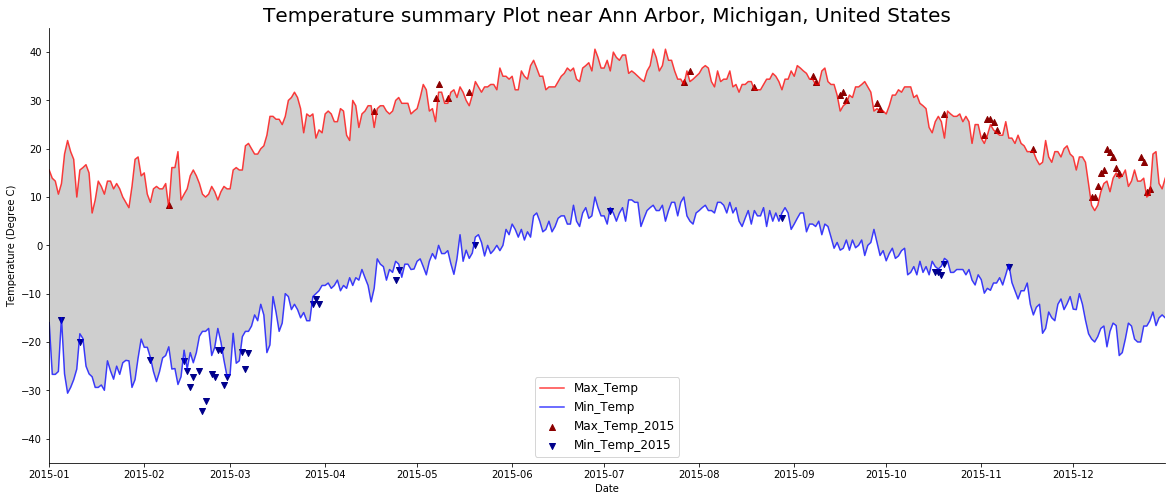

In [6]:
# Plot
%matplotlib inline
import numpy as np

# Create New Figure
plt.figure(figsize = (20,8))

# Plot Formate
plt.xlabel('Date')
plt.ylabel('Temperature (Degree C)')
plt.title('Temperature summary Plot near Ann Arbor, Michigan, United States',fontsize = 20)

# To have size of 365 days
dates = np.arange('2015-01-01', '2016-01-01', dtype='datetime64[D]')

# Get data
pre2015 = pre_2015()  # For Line Plot
get2015 = delta()  # For scattering

# Plot Max ans Min of Pre 2015
plt.plot(dates , pre2015['Max_Temp'] , color = 'red' , alpha = 0.75)
plt.plot(dates , pre2015['Min_Temp'] , color = 'blue' , alpha = 0.75)

# Fill in between
plt.fill_between(dates, pre2015['Max_Temp'] , pre2015['Min_Temp'] , facecolor ='silver', alpha = 0.75)

# Scatter 2015
# Make dates the same as x axis by concatenating 2014 to the Day Of Month
delta_dates = ['2015-'+ str(e) for e in get2015['Day Of Month']]
# Convert it to array to be same as dates
delta_dates = np.asarray(delta_dates, dtype='datetime64[D]', order=None)

# Plot Max and Min 2015
plt.scatter(delta_dates, get2015['Max_Temp_2015'], color = 'darkred' , marker = '^')
plt.scatter(delta_dates, get2015['Min_Temp_2015'], color = 'darkblue' , marker = 'v')
plt.legend(loc=8, title=None, fontsize=12)

# Ink
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set limits [xmin , xmax, ymin, ymax]
ax.axis(['2015-01-01','2015-12-31',-45,45])
plt.savefig('assignment2.png')